In [ ]:
# Module and class setup.

import numpy as np
import copy
import matplotlib.pyplot as plt

def flat_fes(x_vals):
    fes = np.zeros_like(x_vals)
    fes -= fes.min()
    return fes

def shallow_fes(x_vals):
    fes = x_vals**4 - 0.85*x_vals**2
    fes -= fes.min()
    return fes

def deep_fes(x_vals):
    fes = 100*x_vals**4 - 100*x_vals**2
    fes -= fes.min()
    return fes

class Dynamics():
    def __init__(self, fes_func):

        self.x_vals = np.linspace(-1,1,100)
        self.bin_width = self.x_vals[1] - self.x_vals[0]
        self.fes_func = fes_func
        self.underlying_fes = fes_func(self.x_vals)
        
        self.boltz_weights = np.exp(-self.underlying_fes)

        self.underlying_prob_dist = self.boltz_weights / (np.sum(self.boltz_weights)*self.bin_width)

    def dynamics(self,nsteps):
        x_index = np.random.randint(0,len(self.x_vals))
        # x_index = np.where(self.underlying_fes == self.underlying_fes.min())[0][0]
        coord = self.x_vals[x_index]
        self.time = [0]
        self.trajectory = [coord]
        num_acceptances = 0

        for i in range(nsteps):
            rand = np.random.rand()
            self.time.append(i+1)
            
            if rand >= 0.5:
                # Impose PBC
                if (x_index + 1) == 100:
                    trial_index = 0

                else:
                    trial_index = x_index + 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            else:
                # Impose PBC
                if (x_index - 1) == -1:
                    trial_index = 99

                else:
                    trial_index = x_index - 1

                trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
                if trans_prob >= np.random.rand():
                    x_index = trial_index
                    num_acceptances += 1

            coord = self.x_vals[x_index]
            
            self.trajectory.append(coord)
        
        self.acceptance_prob = num_acceptances / nsteps

    def calc_unbiased_prob(self):
        hist, _ = np.histogram(self.trajectory,range=(-1,1),bins=100)

        self.prob_hist = hist/(hist.sum()*self.bin_width)
        weights = np.exp(self.bias,dtype='float128')
        self.unbiased_prob = self.prob_hist*weights

class Umbrella_sampling():
    def __init__(self,numbrellas,kappa,fes_func):

        self.numbrellas = numbrellas
        self.centers = np.linspace(-1,1,numbrellas)
        self.replicas = []
        for i in range(numbrellas):
            replica_window = Dynamics(fes_func)
            replica_window.bias = self.harmonic_restraint((replica_window.x_vals),(self.centers[i]),kappa)
            replica_window.underlying_fes += replica_window.bias
            replica_window.boltz_weights = np.exp(-replica_window.underlying_fes)
            replica_window.underlying_prob_dist = replica_window.boltz_weights / (np.sum(replica_window.boltz_weights)*replica_window.bin_width)
            self.replicas.append(copy.deepcopy(replica_window))

    def dynamics(self,nsteps):
        self.nsteps = nsteps
        for i in range(self.numbrellas):
            self.replicas[i].dynamics(nsteps)
        
    
    def harmonic_restraint(self,x_vals,center,kappa):
        return 0.5 * kappa * (x_vals - center)**2
    
class WHAM():
    def __init__(self,umb_sim,iterations):

        self.umb_sim = umb_sim
        self.f = np.ones(umb_sim.numbrellas)
        self.N = np.ones_like(self.f)*umb_sim.nsteps # This is incorrect, in principle, because the samples are correlated.
        self.c = np.array([np.exp(-window.bias) for window in umb_sim.replicas])

        n = []
        for window in umb_sim.replicas:
            hist, _ = np.histogram(window.trajectory,range=(-1,1),bins=100)
            n.append(hist)
        self.n = np.array(n)

        for i in range(iterations):
            self.calc_p()
            self.calc_f()

        self.calc_G()

    def calc_p(self):
        numerator = np.sum(self.n,axis=0)
        denominator = np.sum((self.N*self.f*self.c.T).T,axis=0)
        self.p = numerator / denominator

    def calc_f(self):
        self.f = 1 / np.sum(self.c*self.p,axis=1)

    def calc_G(self):
        self.G = -np.log(self.p)Energy Barriers

## Free energy as a function of a collective variable.

As we have learned in class, the "Free Energy" of a given microstate of a system is really just a measurement of how likely that microstate is. When in the canonical ensemble (i.e. NVT are constant), this is known as the Helmholtz Free Energy (often denoted by $F$ or $A$). When in the isobaric-isothermal ensemble (i.e. NPT are constant), this quantity is known as the Gibbs free energy ($G$). I will make the (hopefully unoffensive) assumption that the reader identifies more as a chemist than a physicist, and thus more often deals with systems that are under constant pressure. For this reason, I will label the "free energy" as $G$ in the equations that follow. It is worth noting, however, that all of these equations hold in the canonical ensemble by simply swapping $G$ for $F$, so long as one bears in mind that Gibbs and Helmholtz free energies are fundamentally different from one another.

There is a single simple equation that relates the free energy to the probability of a state (see Appendix I for the derivation):

$$G(\mathbf{q}) = -k_BT\ln{P(\mathbf{q})}$$

where $\mathbf{q}$ are the microscopic coordinates of the system (i.e. positions and momenta of particles), $T$ is the temperature in Kelvin, and $k_B$ is the Boltzmann constant with units of energy-per-Kelvin. Again, assuming we're all chemists here, the energies are often reported in per-molar quantities, and in particular, $kJ/mol$ and $kcal/mol$ tend to be of a nice scale for analyzing the types of transitions we're interested in.

Written as functions of $\mathbf{q}$, $G$ and $P$ are $6N$-dimensional quantities, where $N$ is the number of particles in the system. This is seldom useful because of how impossible it becomes to sample such a high-dimensional phase space. Instead we pick some particular degrees of freedom that we are interested in from our simulation. Perhaps you are interested in seeing the distance between two residues in a protein, or the dipole moment for a group of atoms. In the example for today, we study a dihedral angle. The important thing is simply that the so-called "collective variable" of interest can be computed as a function of the microscopic coordinates $\mathbf{q}$. From here, we can reduce the dimensionality of $P$ down to our one reaction coordinate ($s$) using the following equation:

$$P(s) = \int{P(\mathbf{q})\delta(s - s(\mathbf{q}))} \text{d}\mathbf{q}$$

But the truth is that this equation does not have much practical utility for us; it only serves to justify collective variable-based methods. The important thing is the intuition that the free energy can be computed as a function of any CV we want, as long as the CV can be calculated from the microscopic coordinates.

It follows naturally that the free energy can then also be described as a function of $s$:

$$G(s) = -k_BT\ln{{P(s)}}$$

## Exercise 1: Using samples from a simulation to estimate $P(s)$ and $G(S)$.

Let's say we want to compute the free energy barrier of some transition that our system will undergo. The use of collective variables makes this, at least in principle, very simple! At every step in our simulation, we compute the value of the $s(\mathbf{q})$ that we're interested in. We therefore record the trajectory of our simulation in CV space, and can bin those values into a histogram. If we normalize this histogram such that its total area is equal to 1, this serves as an estimate of $P(s)$.

Let's try it! The following cell of code will run a Metropolis Monte Carlo simulation that will sample phase space based on the underlying 1D free energy surface. (See Appendix 2 or look at the source code of the Dynamics class for more information on the algorithm used here.) The 1D free energy surface in this toy model is analogous to the free energy surface in CV space that one might obtain from an MC or MD simulation of a real system. Once you have run the simulation, plot the 

Text(0, 0.5, 'Free Energy')

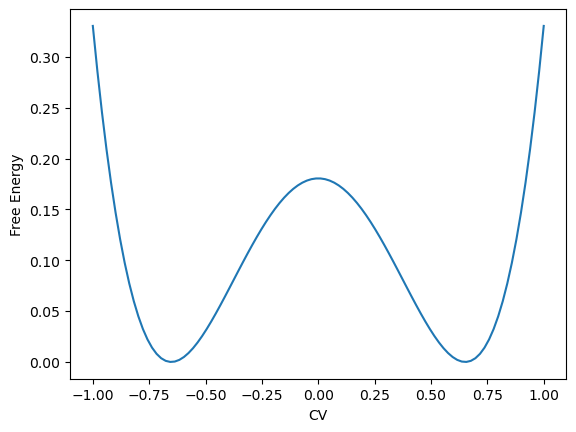

In [10]:
x_vals = np.linspace(-1,1,100)
underlying_fes = shallow_fes(x_vals)
plt.plot(x_vals,underlying_fes)
plt.xlabel('CV')
plt.ylabel('Free Energy')

Text(0, 0.5, 'Probability')

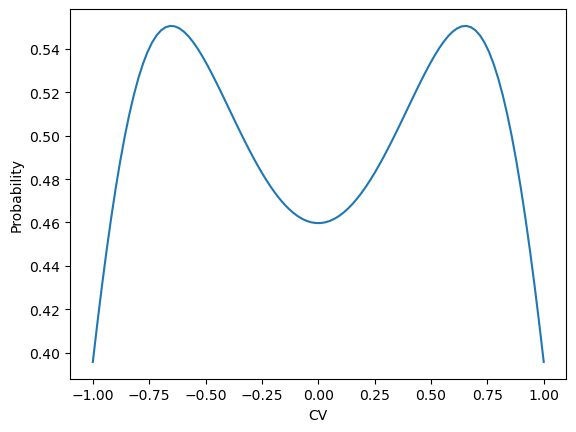

In [ ]:
# In this cell, fill in the blank to compute the expected probability distribution from the underlying FES.
# Hint: To compute exponentials, you can use the np.exp() function implemented in numpy.

kBT = 1

underlying_prob = np.exp(-underlying_fes/kBT) # Your answer here
underlying_prob /= np.sum(underlying_prob*0.02) # Why do I need to renormalize this?

plt.plot(x_vals,underlying_prob)
plt.xlabel('CV')
plt.ylabel('Probability')

The next cell will run the simulation and plot the results against our underlying probability distribution.

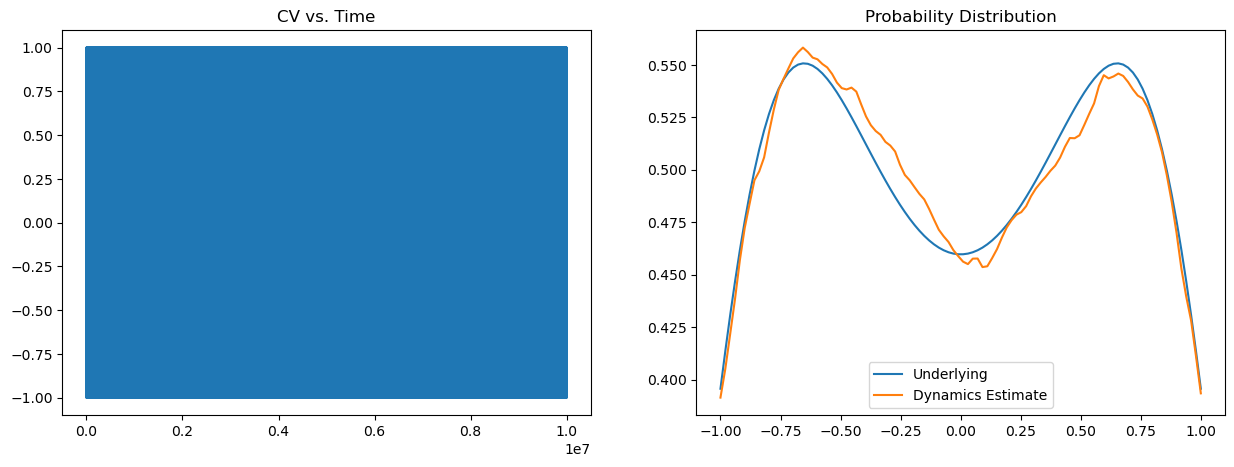

In [23]:
dyn = Dynamics(fes_func=shallow_fes)
dyn.dynamics(10000000)

fig = plt.figure(figsize=(15,5))

ax1 = fig.add_subplot(121)
ax1.plot(dyn.time,dyn.trajectory)
ax1.set_title('CV vs. Time')

hist, _ = np.histogram(dyn.trajectory,range=(-1,1),bins=100,density=True)
ax2 = fig.add_subplot(122)
ax2.plot(dyn.x_vals,underlying_prob,label='Underlying')
ax2.plot(dyn.x_vals,hist,label='Dynamics Estimate')
ax2.set_title('Probability Distribution')
ax2.legend()

In [24]:
print(np.sum(underlying_prob*0.02))
print(np.sum(hist*0.02))

1.0
1.0


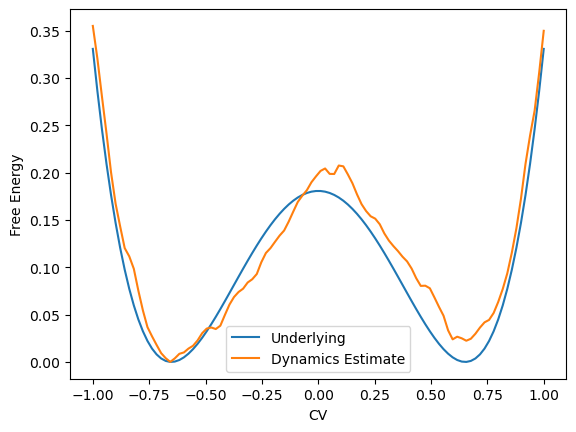

In [26]:
# Now fill in the blank to compute the estimate of the free energy surface from our simulation.
# Hint: Start by figuring out which variable from the previous cell represents the estimate of our probability distribution.

fes = -kBT * np.log(hist) # Fill in blank

plt.plot(x_vals,underlying_fes,label='Underlying')
plt.plot(x_vals,fes-fes.min(),label='Dynamics Estimate')
plt.xlabel('CV')
plt.ylabel('Free Energy')
plt.legend()

## Exercise 2: Overcoming high free-energy barriers.

/tmp/ipykernel_19378/2717550765.py:18: RuntimeWarning: divide by zero encountered in log
  fes = -np.log(hist)


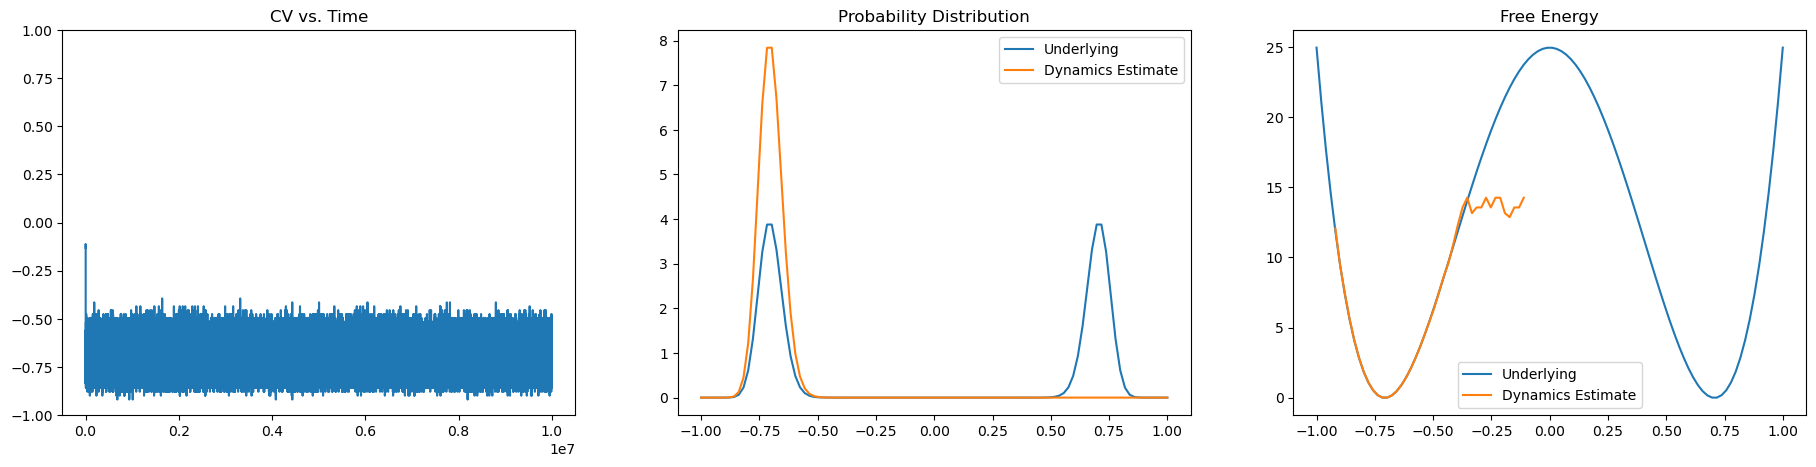

In [17]:
dyn = Dynamics(fes_func=deep_fes)
dyn.dynamics(10000000)

fig = plt.figure(figsize=(22.5,5))

ax1 = fig.add_subplot(131)
ax1.plot(dyn.time,dyn.trajectory)
ax1.set_title('CV vs. Time')
ax1.set_ylim(-1,1)

hist, _ = np.histogram(dyn.trajectory,range=(-1,1),bins=100,density=True)
ax2 = fig.add_subplot(132)
ax2.plot(dyn.x_vals,dyn.underlying_prob_dist,label='Underlying')
ax2.plot(dyn.x_vals,hist,label='Dynamics Estimate')
ax2.set_title('Probability Distribution')
ax2.legend()

fes = -np.log(hist)
ax3 = fig.add_subplot(133)
ax3.plot(dyn.x_vals,dyn.underlying_fes - dyn.underlying_fes.min(),label='Underlying')
ax3.plot(dyn.x_vals,fes-fes.min(),label='Dynamics Estimate')
ax3.set_title('Free Energy')
ax3.legend()

In [109]:
umb = Umbrella_sampling(numbrellas=10,kappa=500,fes_func=deep)
umb.dynamics(1000000)

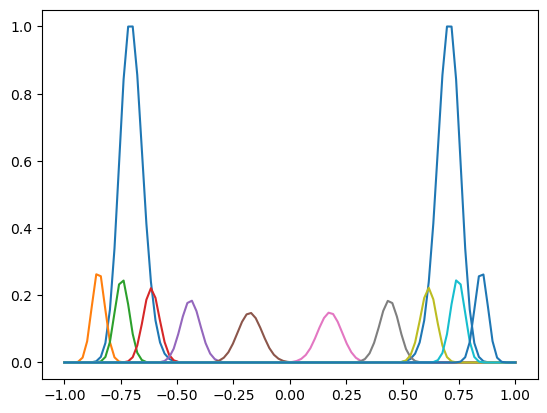

In [110]:
x_vals = umb.replicas[0].x_vals
fes = deep(x_vals)
fes = fes - fes.min()
prob_dist = np.exp(-fes)
plt.plot(x_vals, prob_dist)

for i in range(umb.numbrellas):
    hist, _ = np.histogram(umb.replicas[i].trajectory,range=(-1,1),bins=100)
    hist = hist/hist.sum()
    plt.plot(x_vals,hist)

In [111]:
wham = WHAM(umb,iterations=1000)

/tmp/ipykernel_5849/897901823.py:125: RuntimeWarning: divide by zero encountered in log
  self.G = -np.log(self.p)


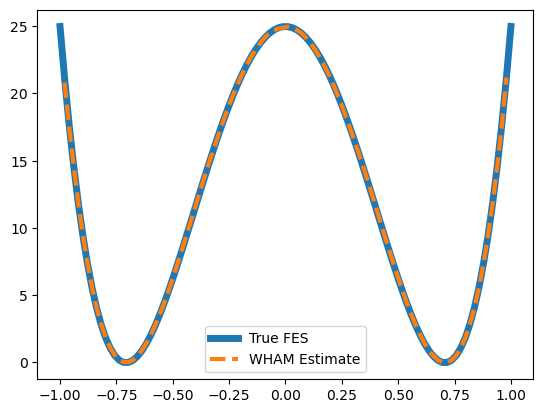

In [116]:
x_vals = umb.replicas[0].x_vals
fes = deep(x_vals)
plt.plot(x_vals,fes-fes.min(), label='True FES',lw=5)
plt.plot(x_vals,wham.G-wham.G.min(),ls='dashed',label='WHAM Estimate',lw=3)
plt.legend()

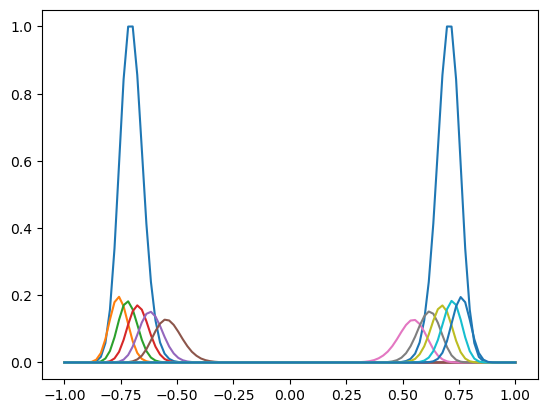

/tmp/ipykernel_5849/897901823.py:125: RuntimeWarning: divide by zero encountered in log
  self.G = -np.log(self.p)


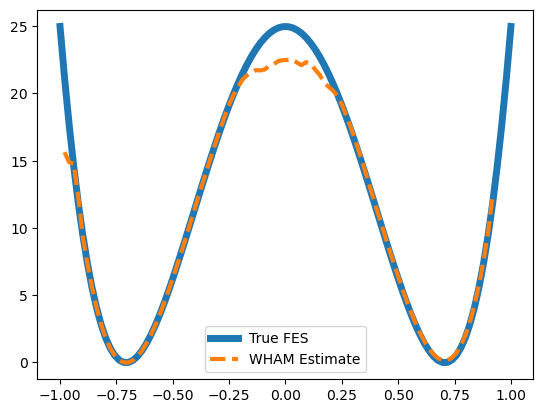

In [119]:
umb = Umbrella_sampling(numbrellas=10,kappa=100,fes_func=deep)
umb.dynamics(1000000)

x_vals = umb.replicas[0].x_vals
fes = deep(x_vals)
fes = fes - fes.min()
prob_dist = np.exp(-fes)
plt.plot(x_vals, prob_dist)

for i in range(umb.numbrellas):
    hist, _ = np.histogram(umb.replicas[i].trajectory,range=(-1,1),bins=100)
    hist = hist/hist.sum()
    plt.plot(x_vals,hist)
plt.show()

wham = WHAM(umb,iterations=1000)

x_vals = umb.replicas[0].x_vals
fes = deep(x_vals)
plt.plot(x_vals,fes-fes.min(), label='True FES',lw=5)
plt.plot(x_vals,wham.G-wham.G.min(),ls='dashed',label='WHAM Estimate',lw=3)
plt.legend()

/tmp/ipykernel_5849/897901823.py:42: RuntimeWarning: invalid value encountered in scalar divide
  trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]
/tmp/ipykernel_5849/897901823.py:55: RuntimeWarning: invalid value encountered in scalar divide
  trans_prob = self.boltz_weights[trial_index] / self.boltz_weights[x_index]


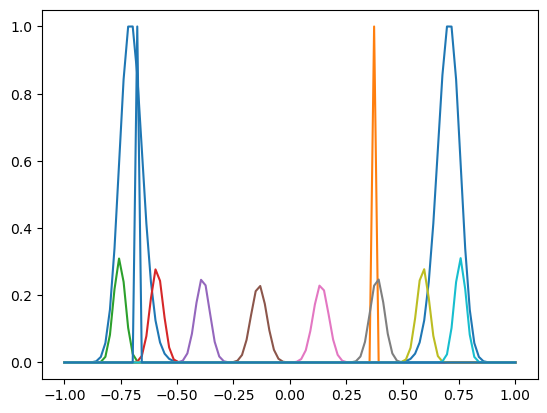

/tmp/ipykernel_5849/897901823.py:125: RuntimeWarning: divide by zero encountered in log
  self.G = -np.log(self.p)


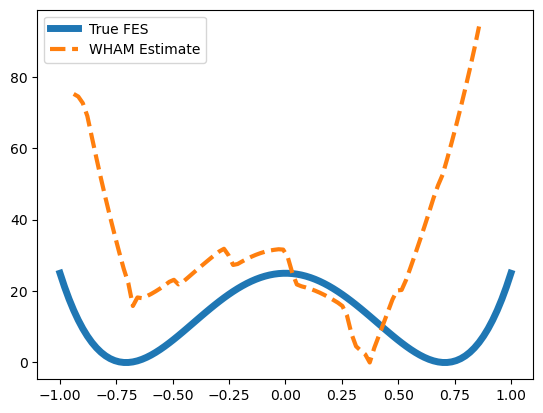

In [121]:
umb = Umbrella_sampling(numbrellas=10,kappa=1000,fes_func=deep)
umb.dynamics(1000000)

x_vals = umb.replicas[0].x_vals
fes = deep(x_vals)
fes = fes - fes.min()
prob_dist = np.exp(-fes)
plt.plot(x_vals, prob_dist)

for i in range(umb.numbrellas):
    hist, _ = np.histogram(umb.replicas[i].trajectory,range=(-1,1),bins=100)
    hist = hist/hist.sum()
    plt.plot(x_vals,hist)
plt.show()

wham = WHAM(umb,iterations=1000)

x_vals = umb.replicas[0].x_vals
fes = deep(x_vals)
plt.plot(x_vals,fes-fes.min(), label='True FES',lw=5)
plt.plot(x_vals,wham.G-wham.G.min(),ls='dashed',label='WHAM Estimate',lw=3)
plt.legend()

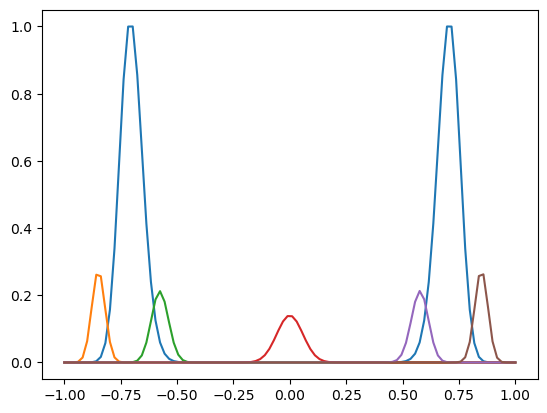

/tmp/ipykernel_5849/897901823.py:125: RuntimeWarning: divide by zero encountered in log
  self.G = -np.log(self.p)


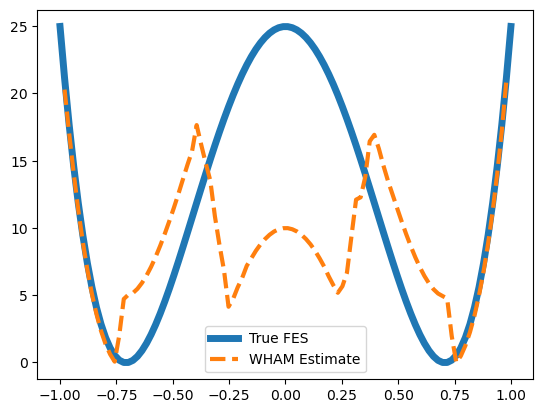

In [122]:
umb = Umbrella_sampling(numbrellas=5,kappa=500,fes_func=deep)
umb.dynamics(1000000)

x_vals = umb.replicas[0].x_vals
fes = deep(x_vals)
fes = fes - fes.min()
prob_dist = np.exp(-fes)
plt.plot(x_vals, prob_dist)

for i in range(umb.numbrellas):
    hist, _ = np.histogram(umb.replicas[i].trajectory,range=(-1,1),bins=100)
    hist = hist/hist.sum()
    plt.plot(x_vals,hist)
plt.show()

wham = WHAM(umb,iterations=1000)

x_vals = umb.replicas[0].x_vals
fes = deep(x_vals)
plt.plot(x_vals,fes-fes.min(), label='True FES',lw=5)
plt.plot(x_vals,wham.G-wham.G.min(),ls='dashed',label='WHAM Estimate',lw=3)
plt.legend()

# Theory

$p_{ij}$ is the biased probability in the j-th bin in the i-th simulation.

$p_j^{\circ}$ is the unbiased probability of bin j.

The two are related by the following equation:

$$p_{ij} = f_ic_{ij}p_j^{\circ}$$

$c_{ij}$ is the biasing factor and $f_i$ is a normalization constant such that $\sum_{j}p_{ij} = 1$. ($f_i^{-1} = \sum_jc_{ij}p_j^{\circ}$).

When a coordinate is biased $c_{ij} = \exp[-\beta V_i(x_j)]$.

It has been derived that the optimal estimate for $p_j^{\circ}$ is

$$p_j^{\circ} = \frac{\sum_{i=1}^S n_{ij}}{\sum_{i=1}^S N_if_ic_{ij}}$$

$n_{ij}$ is the number of couknts in bin j for simulation i. $N_i$ is the number of samples in the $i$-th simulation.